In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## data procecessing

In [2]:
batch_size=8
width = 256
hight = 256
train_path = "D:/Projects/crowdai_train/train"
val_path = "D:/Projects/crowdai_train/val"

In [3]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=40,
        fill_mode='nearest',
        horizontal_flip=True)
val_datagen = ImageDataGenerator()

In [4]:
train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(width,hight),
        batch_size=batch_size,
        class_mode='categorical')

Found 20837 images belonging to 38 classes.


In [5]:
val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=(width,hight),
        batch_size=batch_size,
        class_mode='categorical')

Found 1080 images belonging to 38 classes.


## Resnet Model

In [6]:
from tensorflow.keras.applications.resnet50 import ResNet50

In [7]:
resnet50 = ResNet50(include_top=False,input_shape=(width,hight,3))

Instructions for updating:
Colocations handled automatically by placer.


C:\ProgramData\Anaconda3\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [8]:
resnet50.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalizationV1) (None, 128, 128, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(resnet50)
model.add(Dense(32, activation='relu'))
model.add(Flatten())
model.add(Dense(38, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['categorical_accuracy'])

In [10]:
model.fit_generator(
        generator=train_generator,
        steps_per_epoch=64//batch_size,
        epochs=150,
        validation_data=val_generator,
        validation_steps=32//batch_size
)

Instructions for updating:
Use tf.cast instead.
2605/2605 [==============================] - 474s 182ms/step - loss: 1.5190 - categorical_accuracy: 0.5641 - val_loss: 3.6471 - val_categorical_accuracy: 0.0065


In [20]:
model.save("resnet50.h5")

In [11]:
history = model.history

In [12]:
import pandas as pd
import sys,os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

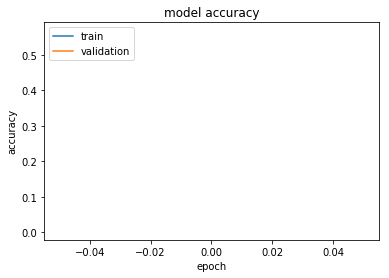

In [13]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

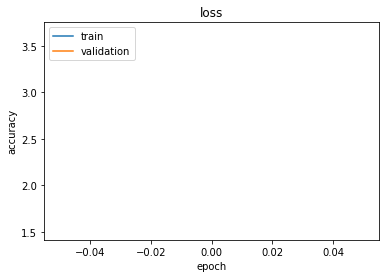

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
prediction = model.predict_generator(val_generator,steps=val_generator.samples/batch_size,verbose=0)

In [17]:
y_pred = np.argmax(prediction,axis=1)
print('Confusion Matrix')
cnf_matrix = confusion_matrix(val_generator.classes, y_pred)
print(cnf_matrix)

Confusion Matrix
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [18]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


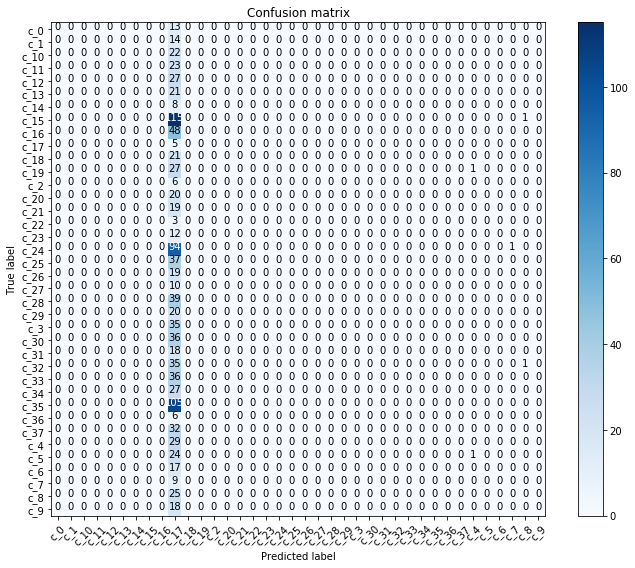

In [19]:
plt.rcParams["figure.figsize"] = (10,8)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=list(val_generator.class_indices.keys()),
                      title='Confusion matrix')